In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [3]:
test_tifs = ['/mnt/zortex-subjects/AH010/2024-01-17/1/mm2_1umpix_laser60p_of_470mw_00001_00007.tif',
             '/mnt/zortex-subjects/AH010/2024-01-17/1/mm2_1umpix_laser60p_of_470mw_00001_00003.tif',
             '/mnt/zortex-subjects/AH010/2024-01-17/1/mm2_1umpix_laser60p_of_470mw_00001_00004.tif',
             '/mnt/zortex-subjects/AH010/2024-01-17/1/mm2_1umpix_laser60p_of_470mw_00001_00011.tif']

In [4]:
%%time
mov_raw = lbmio.load_and_stitch_tifs(test_tifs[:2], planes = n.arange(15), n_ch=15, fix_fastZ=556)

Less than 30 channels specified, not converting plane ids to channel ids
Loading /mnt/zortex-subjects/AH010/2024-01-17/1/mm2_1umpix_laser60p_of_470mw_00001_00007.tif
Loading /mnt/zortex-subjects/AH010/2024-01-17/1/mm2_1umpix_laser60p_of_470mw_00001_00003.tif
Loaded 2 files, total 5.64 GB
CPU times: user 2.28 s, sys: 13.1 s, total: 15.4 s
Wall time: 27.1 s


In [5]:
savedir = '/mnt/md0/runs/AH010/2024-01-17'
exp_str = 'AH010_2024-01-17_5'

In [6]:
job = Job(savedir,exp_str,create=False)

   Found and loaded params from /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/params.npy


In [33]:

job.params['t_batch_size'] = 300
job.params['intensity_thresh'] = (0.1)
job.params['n_svd_comp'] = (50), # if you have multiple values here, make sure you pass mov=svd_info
job.params['conv_filt_xy']= 2.5
job.params['npil_filt_xy']= 20.0
job.params['conv_filt_z'] = 1.0
job.params['npil_filt_z'] = 1.0
job.params['sdnorm_exp'] = 1.0

In [142]:
mov = job.get_registered_movie()[:,::6][:,:400].compute()

In [191]:
summary = job.load_summary()

In [197]:
rigid_xs, rigid_ys, nonrigid_xs, nonrigid_ys = job.load_registration_results()

In [303]:
nz,ny,nx = summary['ref_img_3d'].shape

In [ ]:
x = 1

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f9d27338070>)

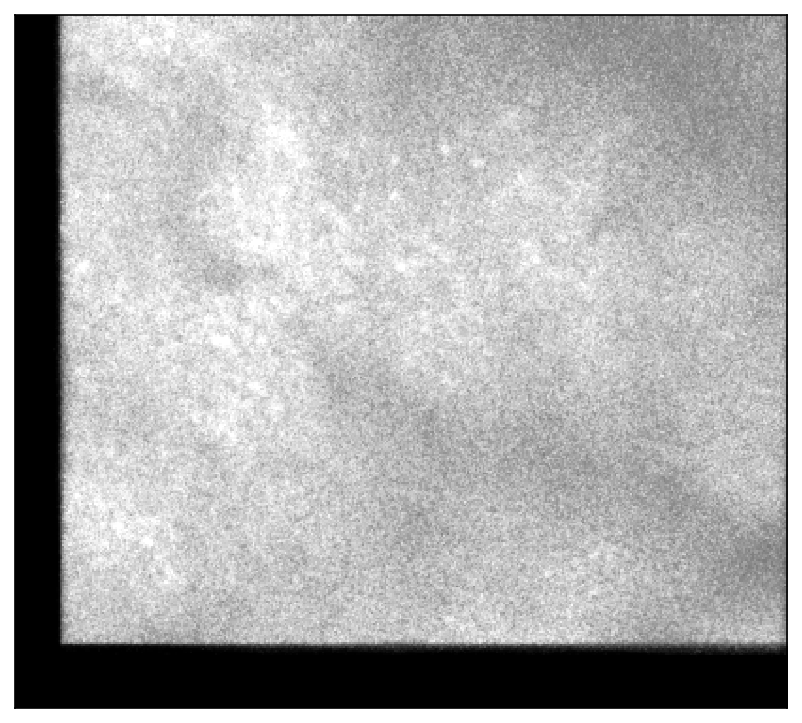

In [383]:
tfu.show_tif(mov[0].mean(axis=0))

In [144]:
from suite3d import iter_step

In [145]:
params = job.params.copy()

In [189]:
params['npil_filt_type'] = 'unif'
params['conv_filt_type'] = 'gaussian'
params['conv_filt_xy'] = 2.5
params['npil_filt_xy'] = 5
params['intensity_thresh'] = 0

In [147]:
mov_zerod = mov.copy()
mov_zerod[:,:,:100] = 0
mov_zerod[:,:,:,:100] = 0
mov_zerod[:,:,-100:] = 0
mov_zerod[:,:,:,-100:] = 0

In [162]:
nz, nt, ny, nx = mov.shape

In [173]:
dx = 3; dy = 4
mov_staggered = mov.copy()
for i in range(nz):
    mov_staggered[i,:,:100+dy*i] = 0
    mov_staggered[i,:,-(100-dy*i):] = 0
    mov_staggered[i,:,:, :100+dx*i] = 0
    mov_staggered[i,:,:, -(100-dx*i):] = 0

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f9d2fa81610>)

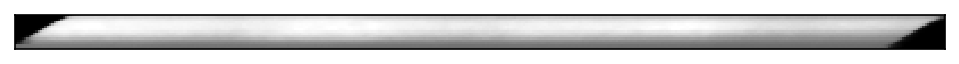

In [175]:
tfu.show_tif(mov.mean(axis=(1,2)))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f9d2fb30370>)

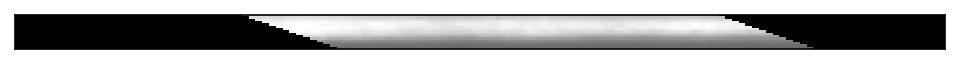

In [174]:
tfu.show_tif(mov_staggered.mean(axis=(1,2)))

In [181]:
(sdnorm_stag, mov_filt_stag, mov_sub_stag), vmap_stag = iter_step.calculate_corrmap(mov_staggered, params, 
                                                                                        job.dirs, save=False, return_mov_filt=True, iter_limit = 1)

Using conv_filt: gaussian, 1.00, 2.50
Using np_filt: unif, 1.00, 5.00
Running only 1 iters
Running batch 1 of 1
Will process 300 frames (0-300, t_batch_size: 300)
Loaded and swapped, idx 0 to 300
Calculating corr map
Rolling mean filter
Stdev over time
Sharr creation
Sub and conv
Vmap
Calculated corr map in 12.23 seconds


In [176]:
(sdnorm_zerod, mov_filt_zerod, mov_sub_zerod), vmap_zerod = iter_step.calculate_corrmap(mov_zerod, params, 
                                                                                        job.dirs, save=False, return_mov_filt=True, iter_limit = 1)

Using conv_filt: gaussian, 1.00, 2.50
Using np_filt: unif, 1.00, 5.00
Running only 1 iters
Running batch 1 of 1
Will process 300 frames (0-300, t_batch_size: 300)
Loaded and swapped, idx 0 to 300
Calculating corr map
Rolling mean filter
Stdev over time
Sharr creation
Sub and conv
Vmap
Calculated corr map in 14.09 seconds


In [177]:
(sdnorm, mov_filt, mov_sub), vmap = iter_step.calculate_corrmap(mov, params, job.dirs, save=False, return_mov_filt=True, iter_limit = 1)

Using conv_filt: gaussian, 1.00, 2.50
Using np_filt: unif, 1.00, 5.00
Running only 1 iters
Running batch 1 of 1
Will process 300 frames (0-300, t_batch_size: 300)
Loaded and swapped, idx 0 to 300
Calculating corr map
Rolling mean filter
Stdev over time
Sharr creation
Sub and conv
Vmap
Calculated corr map in 13.75 seconds


In [ ]:
__, vmap_edgecrop = iter_step.calculate_corrmap(mov_edgecrop, params, job.dirs, save=False, return_mov_filt=True, iter_limit = 1)

Using conv_filt: gaussian, 1.00, 2.50
Using np_filt: unif, 1.00, 5.00
Running only 1 iters
Running batch 1 of 1
Will process 300 frames (0-300, t_batch_size: 300)
Loaded and swapped, idx 0 to 300
Calculating corr map
Rolling mean filter
Stdev over time
Sharr creation
Sub and conv
Vmap


(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f9d2cf08ac0>)

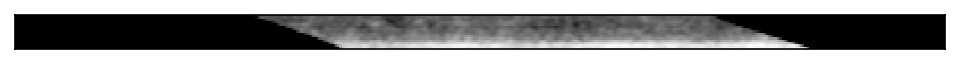

In [185]:
tfu.show_tif(vmap_stag.mean(axis=1), vminmax_percentile=(50,100))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f9d2ceca310>)

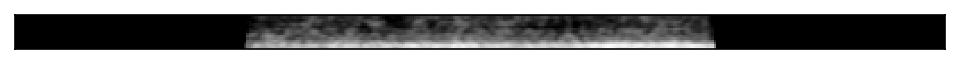

In [186]:
tfu.show_tif(vmap_zerod.mean(axis=1), vminmax_percentile=(50,100))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f9d2ce8e130>)

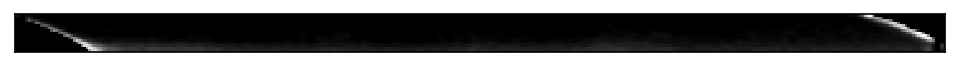

In [187]:
tfu.show_tif(vmap.mean(axis=2), vminmax_percentile=(50,100))

In [ ]:
tfu.show_tif(vmap_edgecrop.mean(axis=2), vminmax_percentile=(50,100))

In [ ]:
tfu.show_tif(vmap[5], vminmax_percentile=(50,100))

In [ ]:
tfu.show_tif(vmap_edgecrop[5], vminmax_percentile=(50,100))